# RXRX.AI

> disclosure: some lines of code were taken from other kernels available on the Kaggle's competition link https://www.kaggle.com/c/recursion-cellular-image-classification/kernels . Authors will be cited as much as possible where appropriate.

In [53]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rxrx.io as rio

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR

from torchvision import models, transforms as T

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [54]:
# Data folder overview
print(os.listdir("./data"))

['pixel_stats.csv', 'train', 'test_controls.csv', 'recursion_dataset_license.pdf', 'test', 'train_controls.csv', 'sample_submission.csv', 'train.csv', 'test.csv']


## Loading a site and visualizing individual channels

This exploration is inspired by the competition's [creator notebook](https://colab.research.google.com/github/recursionpharma/rxrx1-utils/blob/master/notebooks/visualization.ipynb) and [utils](https://github.com/recursionpharma/rxrx1-utils).   
  
The input for our model will be a 512x512x6 image tensor representing a site, so we will make sure the utilities provided load the site as a tensor with the proper shape. Here, we request the image in experiment RPE-05 on plate 3 in well D19 at site 2.

In [55]:
t = rio.load_site('train', 'RPE-05', 3, 'D19', 2, base_path="./data")
t.shape

(512, 512, 6)

This seems to work, now let's visualize individual channels.

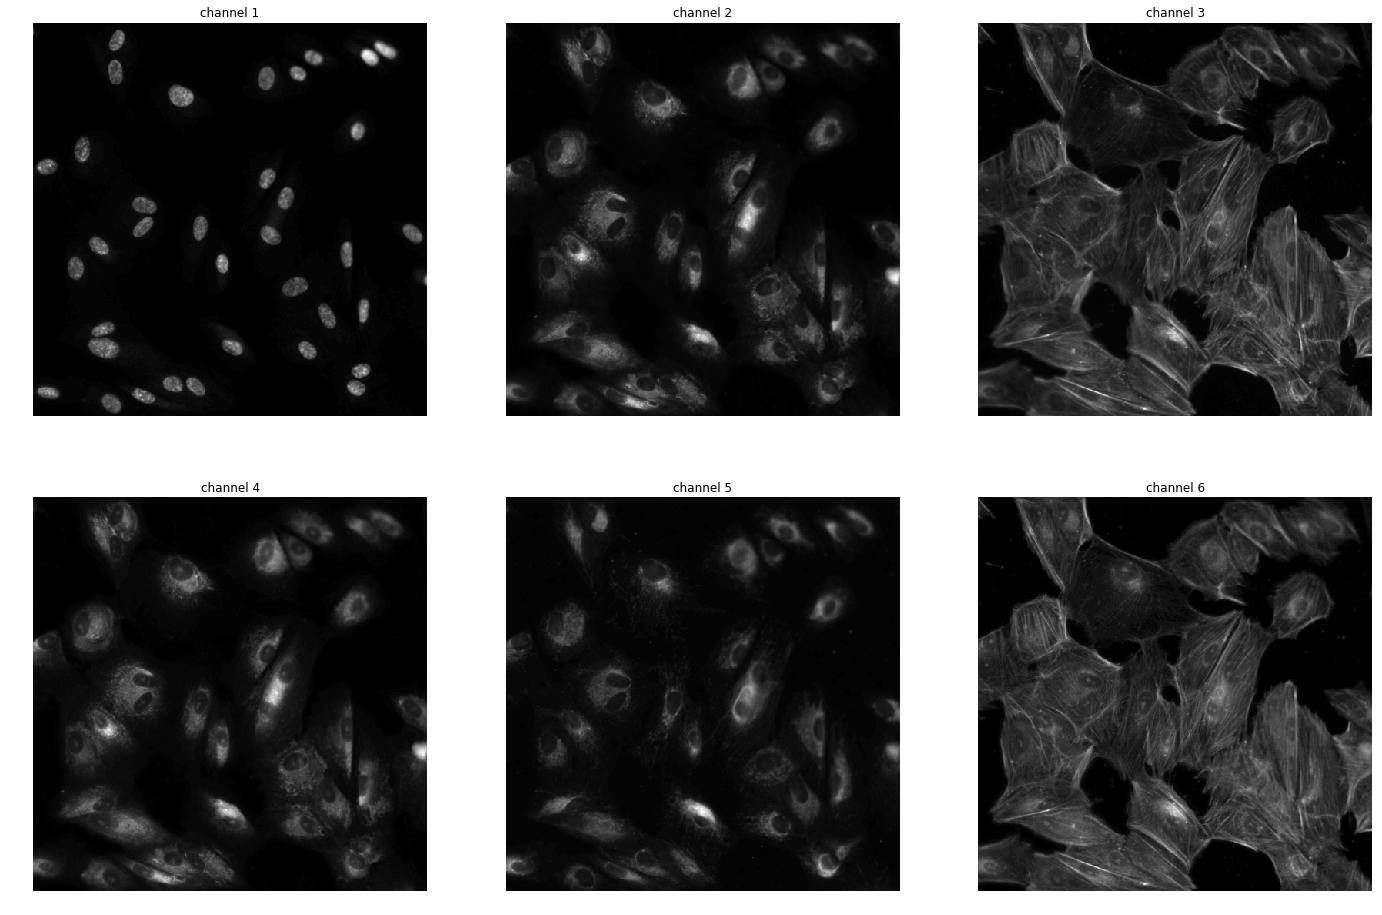

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

for i, ax in enumerate(axes.flatten()):
  ax.axis('off')
  ax.set_title('channel {}'.format(i + 1))
  _ = ax.imshow(t[:, :, i], cmap='gray')

With the utils provided, we can also convert a site to a RGB format with the `convert_tensor_to_rgb` method. It associates an RGB color with each channel, then aggregates the color channels across the six cellular channels.   

(512, 512, 3)


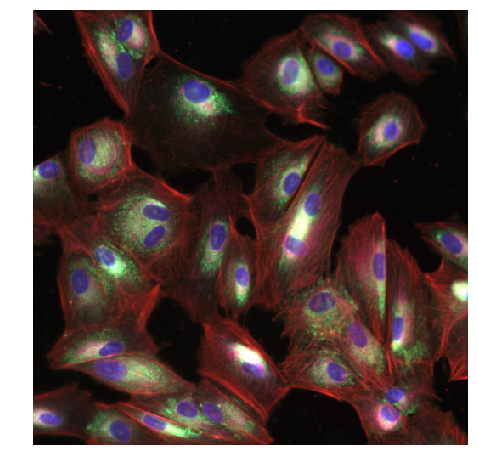

In [57]:
x = rio.convert_tensor_to_rgb(t)
print(x.shape)

# plot RGB Image
plt.figure(figsize=(8, 8))
plt.axis('off')
_ = plt.imshow(x)

The utils also include a wrapper `load_site_as_rgb` combining the last two functions.

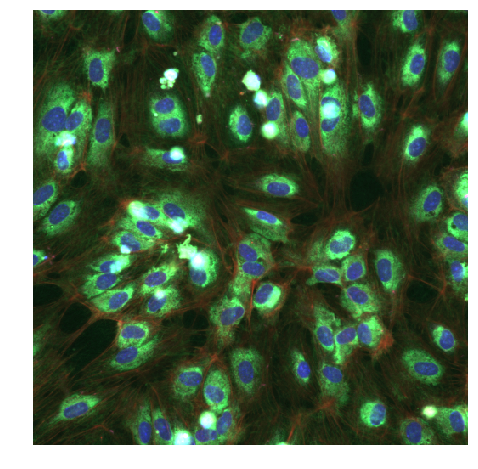

In [58]:
y = rio.load_site_as_rgb('train', 'HUVEC-07', 4, 'K09', 1)

plt.figure(figsize=(8, 8))
plt.axis('off')

_ = plt.imshow(y)

## Metadata

The metadata for RxRx1 during the Kaggle competition is broken up into four files: train.csv, train_controls.csv, test.csv and test_controls.csv. It is often more convenient to view all the metadata at once, so we have provided a helper function called combine_metadata for doing just that.

In [59]:
md = rio.combine_metadata()
md.head()

,cell_type,dataset,experiment,plate,sirna,site,well,well_type
id_code,,,,,,,,
HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,1138.0,1,B02,negative_control
HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,1138.0,2,B02,negative_control
HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,NaN,1,B03,treatment
HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,NaN,2,B03,treatment
HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,NaN,1,B04,treatment


## ResNet18 baseline

The following baseline model is inspired by [Michael Diskin's work](https://www.kaggle.com/yhn112/resnet18-baseline-pytorch-ignite).   

### Implement dataset class

In [60]:
path_data = './data'
device = 'cuda'
torch.manual_seed(0)

In [61]:
class ImagesDS(D.Dataset):
    def __init__(self, df, img_dir, mode='train', site=1, channels=[1,2,3,4,5,6]):
        self.records = df.to_records(index=False)
        self.channels = channels
        self.site = site
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
        
    @staticmethod
    def _load_img_as_tensor(file_name):
        with Image.open(file_name) as img:
            return T.ToTensor()(img)

    def _get_img_path(self, index, channel):
        experiment, well, plate = self.records[index].experiment, self.records[index].well, self.records[index].plate
        return '/'.join([self.img_dir,self.mode,experiment,f'Plate{plate}',f'{well}_s{self.site}_w{channel}.png'])
        
    def __getitem__(self, index):
        paths = [self._get_img_path(index, ch) for ch in self.channels]
        img = torch.cat([self._load_img_as_tensor(img_path) for img_path in paths])
        if self.mode == 'train':
            return img, int(self.records[index].sirna)
        else:
            return img, self.records[index].id_code

    def __len__(self):
        return self.len

In [62]:
df = pd.read_csv(path_data+'/train.csv')
df_train, df_val = train_test_split(
    df,
    test_size = 0.035,
    stratify = df.sirna,
    random_state=42
)
df_test = pd.read_csv(path_data+'/test.csv')

In [63]:
ds = ImagesDS(df_train, path_data, mode='train')
ds_val = ImagesDS(df_val, path_data, mode='train')
ds_test = ImagesDS(df_test, path_data, mode='test')

In [64]:
classes = 1108
batch_size = 32
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, classes)

# let's make our model work with 6 channels
trained_kernel = model.conv1.weight
new_conv = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
with torch.no_grad():
    new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*6, dim=1)
model.conv1 = new_conv

In [65]:
loader = D.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = D.DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4)
tloader = D.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=4)

### Train model

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

metrics = {
    'loss': Loss(criterion),
    'accuracy': Accuracy(),
}


trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

AssertionError: Torch not compiled with CUDA enabled

Attach to our trainer a function to run a validator at the end of each epoch. We'll also add a learning scheduler to decrease LR after each epoch, early stopping and checkpoints.

In [ ]:
# Validator
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    metrics = val_evaluator.run(val_loader).metrics
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} "
          .format(engine.state.epoch, 
                      metrics['loss'], 
                      metrics['accuracy']))
    
# Learning scheduler
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)
@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    lr = float(optimizer.param_groups[0]['lr'])
    print("Learning rate: {}".format(lr))
    
# Early stopping
handler = EarlyStopping(patience=6, score_function=lambda engine: engine.state.metrics['accuracy'], trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

# Checkpoints
checkpoints = ModelCheckpoint('models', 'Model', save_interval=3, n_saved=3, create_dir=True)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoints, {'ResNet18': model})

# Progress Bar
pbar = ProgressBar(bar_format='')
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

### Train and evaluate

In [ ]:
# Train
trainer.run(loader, max_epochs=50)

In [ ]:
# Eval
model.eval()
with torch.no_grad():
    preds = np.empty(0)
    for x, _ in tqdm_notebook(tloader): 
        x = x.to(device)
        output = model(x)
        idx = output.max(dim=-1)[1].cpu().numpy()
        preds = np.append(preds, idx, axis=0)

In [ ]:
# Submission
submission = pd.read_csv(path_data + '/test.csv')
submission['sirna'] = preds.astype(int)
submission.to_csv('submission.csv', index=False, columns=['id_code','sirna'])